# Day 08. Exercise 00
# Binary classifier. Logistic regression

## 0. Imports

In [419]:
import pandas as pd
import sqlite3
# from sklearn.ensemble import RandomForestClassifier
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## 1. Preprocessing

- Get the data from the file [`checker-timestamp.csv`](https://drive.google.com/file/d/1pooM4cITtG249msX3GK_6W0eEiblzAf5/view?usp=sharing).


- Create a dataframe `df` with the columns: `date`, `am`, `pm`, `target`, where `date` is the date of the day, `am` is the number of the commits during the day before midday (integer), `pm` is the number of commits during the day after midday (integer), `target` is weekend/working_day.

In [357]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [358]:
df = pd.read_csv('/content/drive/MyDrive/ex08_42/checker_timestamp.csv')
df


,timestamp
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370
...,...
3202,2020-05-21 20:19:06.872761
3203,2020-05-21 20:22:41.785725
3204,2020-05-21 20:22:41.877806
3205,2020-05-21 20:37:00.129678


In [359]:
d = {}
df_new = pd.DataFrame(d)
df['hour'] = df['timestamp'].astype('datetime64[ns]').dt.hour
df

,timestamp,hour
0,2020-04-17 05:19:02.744528,5
1,2020-04-17 05:22:35.249331,5
2,2020-04-17 05:22:45.549397,5
3,2020-04-17 05:34:14.691200,5
4,2020-04-17 05:34:24.422370,5
...,...,...
3202,2020-05-21 20:19:06.872761,20
3203,2020-05-21 20:22:41.785725,20
3204,2020-05-21 20:22:41.877806,20
3205,2020-05-21 20:37:00.129678,20


In [360]:
ranges = [-1, 4, 7, 11, 17, 20, 24]
labels = ['before midday', 'after midday']

df['daytime'] = pd.cut(df['hour'], bins=[-1, 12, 24], labels=labels)

In [361]:
df['day'] = list(map(lambda x: x.split(' ')[0], df['timestamp']))
df

,timestamp,hour,daytime,day
0,2020-04-17 05:19:02.744528,5,before midday,2020-04-17
1,2020-04-17 05:22:35.249331,5,before midday,2020-04-17
2,2020-04-17 05:22:45.549397,5,before midday,2020-04-17
3,2020-04-17 05:34:14.691200,5,before midday,2020-04-17
4,2020-04-17 05:34:24.422370,5,before midday,2020-04-17
...,...,...,...,...
3202,2020-05-21 20:19:06.872761,20,after midday,2020-05-21
3203,2020-05-21 20:22:41.785725,20,after midday,2020-05-21
3204,2020-05-21 20:22:41.877806,20,after midday,2020-05-21
3205,2020-05-21 20:37:00.129678,20,after midday,2020-05-21


In [362]:
# df['date_1'] = df['timestamp'].dt.hou
working_day = df.loc[df['timestamp'].astype('datetime64[ns]').dt.dayofweek < 5]
working_day.reset_index(inplace=True)
working_day

,index,timestamp,hour,daytime,day
0,0,2020-04-17 05:19:02.744528,5,before midday,2020-04-17
1,1,2020-04-17 05:22:35.249331,5,before midday,2020-04-17
2,2,2020-04-17 05:22:45.549397,5,before midday,2020-04-17
3,3,2020-04-17 05:34:14.691200,5,before midday,2020-04-17
4,4,2020-04-17 05:34:24.422370,5,before midday,2020-04-17
...,...,...,...,...,...
2032,3202,2020-05-21 20:19:06.872761,20,after midday,2020-05-21
2033,3203,2020-05-21 20:22:41.785725,20,after midday,2020-05-21
2034,3204,2020-05-21 20:22:41.877806,20,after midday,2020-05-21
2035,3205,2020-05-21 20:37:00.129678,20,after midday,2020-05-21


In [363]:
weekend = df.loc[df['day'].astype('datetime64[ns]').dt.dayofweek >= 5]
weekend.reset_index(inplace=True)
weekend

,index,timestamp,hour,daytime,day
0,23,2020-04-18 07:56:45.408648,7,before midday,2020-04-18
1,24,2020-04-18 13:36:53.971502,13,after midday,2020-04-18
2,25,2020-04-18 13:42:35.482008,13,after midday,2020-04-18
3,26,2020-04-18 13:51:22.291271,13,after midday,2020-04-18
4,27,2020-04-18 13:53:17.230725,13,after midday,2020-04-18
...,...,...,...,...,...
1165,3088,2020-05-17 22:23:05.744415,22,after midday,2020-05-17
1166,3089,2020-05-17 22:23:11.078664,22,after midday,2020-05-17
1167,3090,2020-05-17 22:23:11.220412,22,after midday,2020-05-17
1168,3091,2020-05-17 22:25:15.051189,22,after midday,2020-05-17


In [366]:
count_commit_working_day = working_day.groupby(['day', 'daytime'], group_keys=['day', 'daytime']).count()
am = [count_commit_working_day['timestamp'][i]  for i in range(0, len(count_commit_working_day['timestamp'])) if i%2 == 0]
pm = [count_commit_working_day['timestamp'][i]  for i in range(0, len(count_commit_working_day['timestamp'])) if i%2 == 1]
s = pd.Series([count_commit_working_day.index[i][0]  for i in range(0, len(count_commit_working_day.index))])
s = s.unique()
df_new['data'] = s
df_new['am'] = am
df_new['pm'] = pm
df_new['target'] = 0
df_new
# am



,data,am,pm,target
0,2020-04-17,23,0,0
1,2020-04-20,2,23,0
2,2020-04-21,0,25,0
3,2020-04-22,1,27,0
4,2020-04-23,14,29,0
5,2020-04-24,2,14,0
6,2020-04-27,4,2,0
7,2020-04-28,4,1,0
8,2020-04-29,0,17,0
9,2020-04-30,13,40,0


In [368]:
df_new_2 = pd.DataFrame(d)
count_commit_weekend_day = weekend.groupby(['day', 'daytime'], group_keys=['day', 'daytime']).count()
am = [count_commit_weekend_day['timestamp'][i]  for i in range(0, len(count_commit_weekend_day['timestamp'])) if i%2 == 0]
pm = [count_commit_weekend_day['timestamp'][i]  for i in range(0, len(count_commit_weekend_day['timestamp'])) if i%2 == 1]
s = pd.Series([count_commit_weekend_day.index[i][0]  for i in range(0, len(count_commit_weekend_day.index))])
s = s.unique()
df_new_2['data'] = s
df_new_2['am'] = am
df_new_2['pm'] = pm
df_new_2['target'] = 1
df_new_2



,data,am,pm,target
0,2020-04-18,1,68,1
1,2020-04-19,18,15,1
2,2020-04-25,37,67,1
3,2020-04-26,42,219,1
4,2020-05-02,110,132,1
5,2020-05-03,61,119,1
6,2020-05-09,2,84,1
7,2020-05-10,11,132,1
8,2020-05-16,0,4,1
9,2020-05-17,2,46,1


In [387]:
df_new_end = pd.concat([df_new, df_new_2])
# df_new_end.reindex(range(len(df_new_end)),method='ffill')
df_new_end
index = [i for i in range(0, len(df_new_end))]
df_new_end_2 = df_new_end.reset_index()
df_new_end_2 = df_new_end_2.drop('index', axis=1)
df_new_end_2
# df_new_end.set_index('data')

# ser3.reindex(range(6),method='ffill')

,data,am,pm,target
0,2020-04-17,23,0,0
1,2020-04-20,2,23,0
2,2020-04-21,0,25,0
3,2020-04-22,1,27,0
4,2020-04-23,14,29,0
5,2020-04-24,2,14,0
6,2020-04-27,4,2,0
7,2020-04-28,4,1,0
8,2020-04-29,0,17,0
9,2020-04-30,13,40,0


## 2. Exploratory analysis

- Create a plot where `x` is am, `y` is pm, each dot is a day, working days and weekends must have different colors.


- By looking at the graph do you think it will be easy to classify the days having those two features? Put your answer in the markdown cell in the end of that sectioin: "yes, it is easy" or "no, it is not easy".

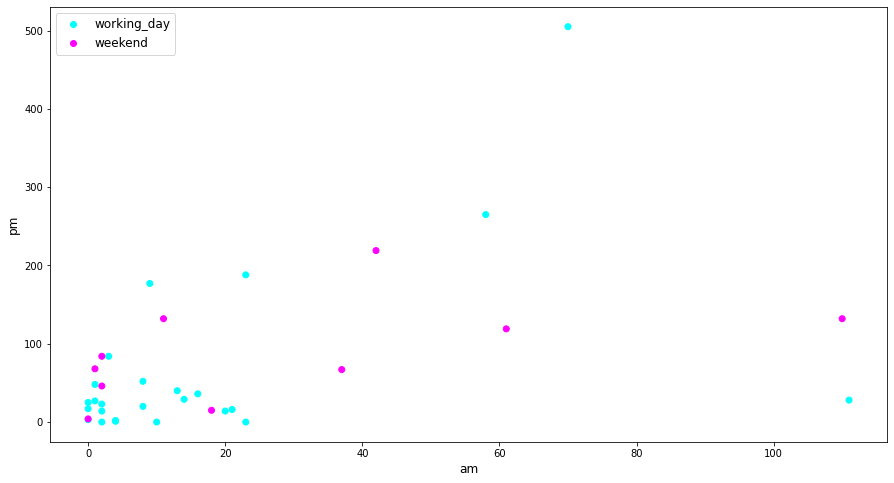

In [388]:
fig, ax = plt.subplots(figsize=(15, 8))
scatter = ax.scatter(x=df_new_end['am'], y=df_new_end['pm'],
           c=np.where(df_new_end['target'] == 0, 0, 1), cmap='cool')
ax.set_xlabel('am', fontsize='large')
ax.set_ylabel('pm', fontsize='large')
handles, labels = scatter.legend_elements(prop='colors')
ax.legend(handles, ['working_day', 'weekend'],
          loc='upper left', fontsize='large')
plt.show()

## 3. Logistic regression

- Train logistic regression on your data using `am` and `pm`, parameters are: `random state=21`, `fit_intercept=False`.


- Make predictions for every day of your dataset and add them to your dataframe with the column name `predict`.


- Save the dataframe into a file in the subfolder of the day `data` with the name `am_pm.csv`.


- Draw another plot like you did before, but the color should be taken from the `predict`.


- By looking at the graph do you think if it made good predictions? Put your answer in the markdown cell in the end of that section: "yes, it is good"; "no, it is not good".

In [391]:
X = df_new_end_2.drop('target', axis = 1)
X = X.drop('data', axis = 1)
X

,am,pm
0,23,0
1,2,23
2,0,25
3,1,27
4,14,29
5,2,14
6,4,2
7,4,1
8,0,17
9,13,40


In [406]:
y = np.where(df_new_end_2['target'] == 0, 0, 1)
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [407]:
clf = LogisticRegression(random_state=21, fit_intercept=False)

In [408]:
clf.fit(X, y)

LogisticRegression(fit_intercept=False, random_state=21)

In [409]:
cv_pred = clf.predict(X)
cv_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [410]:
df_new_end_2['predict'] = cv_pred
df_new_end

,data,am,pm,target,predict
0,2020-04-17,23,0,0,0
1,2020-04-20,2,23,0,0
2,2020-04-21,0,25,0,0
3,2020-04-22,1,27,0,0
4,2020-04-23,14,29,0,0
5,2020-04-24,2,14,0,0
6,2020-04-27,4,2,0,0
7,2020-04-28,4,1,0,0
8,2020-04-29,0,17,0,0
9,2020-04-30,13,40,0,0


In [412]:
df_new_end_2.to_csv('/content/drive/MyDrive/ex08_42/am_pm.csv', index = False)

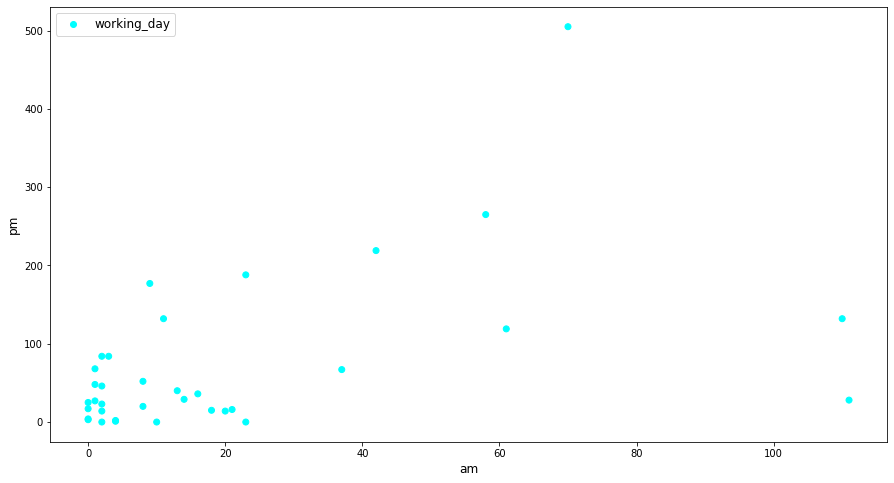

In [413]:
fig, ax = plt.subplots(figsize=(15, 8))
scatter = ax.scatter(x=df_new_end['am'], y=df_new_end['pm'],
           c=np.where(df_new_end['predict'] == 0, 0, 1), cmap='cool')
ax.set_xlabel('am', fontsize='large')
ax.set_ylabel('pm', fontsize='large')
handles, labels = scatter.legend_elements(prop='colors')
ax.legend(handles, ['working_day', 'weekend'],
          loc='upper left', fontsize='large')
plt.show()

no, it is not good

## 4. Evaluation

- Calculate `accuracy` for your predictions.


- Calculate `accuracy` for the naive case when each of your prediction is the value of your most popular class of the day.


- Comparing the accuracies do you think that the classifier made good predictions? Put your answer in the markdown cell in the end of the secion: "yes, it is good"; "no, it is not good".

In [425]:
accuracy_score(cv_pred, y)

0.7142857142857143

no, it is not good